**Question 1**.

Firstly, let's define the network parameters relevant to our problem.

$L$: number of network layers, such that $\ell \in \{1, \ldots, L-1\}$

$W^{(\ell)}$: A weight matrix for the $\ell^{th}$ layer, where the entry $w_{jk}^{(\ell)}$ represents the weight from the $k^{th}$ nueron in the $(\ell - 1)^{th}$ layer to the $j^{th}$ neuron in the $\ell^{th}$ layer 

$b^{(\ell)}$: A bias vector whose $j^{th}$ entry is the bias term for the $j^{th}$ neuron in layer $\ell$

$z_j^{(\ell)} = W^{\ell}a^{(\ell - 1)} + b^{(\ell)}$: the $j^{th}$ weighted input for the $\ell^{th}$ layer

$a_j^{(\ell)} = \sigma (z_j^{(\ell)})$: The $j^{th}$ activated neuron in the $\ell^{th}$ layer

Now, in order to derive an expression for $\frac{\partial E}{\partial b_i^{(\ell)}}$, we must first introduce an intermediary quantity, $\delta_i^{(\ell)}$, which we'll define as the the error in the $i^{th}$ neuron in the $\ell^{th}$ layer. This term has the following general equation:

$$
\begin{aligned}
\delta_i^{(\ell)} = \frac{\partial E}{\partial z_i^{(\ell)}}.
\end{aligned}
$$

With this term we are ready to derive $\frac{\partial E}{\partial b_i^{(\ell)}}$, however, we'll lay some additional conceptual framework first, simplifying the later task of explaining how $\frac{\partial E}{\partial b_i^{(\ell)}}$ is computed during training.

We begin by defining a singular error, in particular, $\delta_j^{L}$, the error in the $j^th$ nueron in the last layer. Using our general definition above as well as the chain rule, we can rewrite $\delta_j^{(L)}$ as

$$
\begin{aligned}
\delta_j^{(L)} = \frac{\partial E}{\partial a_j^{(L)}}\frac{\partial a_j^{(L)}}{\partial z_j^{(L)}}.
\end{aligned}
$$

Using this singular piece, we write the vector of errors in the last layer as

$$
\delta^{(L)} = \nabla_a E \odot \sigma'(z^{(L)}).
$$

Now, with this key concept, let's define, $\delta^{(\ell)}$, the vector of errors associated with an arbitrary layer of neurons $\ell$:

$$
\begin{aligned}
\delta^{(l)} = \left([W^{(\ell + 1)}]^T\delta^{(\ell + 1)}\right) \odot \sigma'(z^{(\ell)}).
\end{aligned}
$$

Within this equation lies the idea of $\textit{backpropagation}$. To see why, let's look at how this calculation plays out for a singular neuron in the $\ell^{th}$ layer. Examining neuron $a_j^{\ell}$, the equation for $\delta_j^{(\ell)}$ becomes 

$$
\left([W^{(\ell + 1)}]^T_{j} \cdot \delta^{(\ell + 1)}\right)* \frac{\partial a_j^{(\ell)}}{\partial z_j^{(\ell)}},
$$

where $[W^{(\ell + 1)}]^T_{j}$ is the $j^{th}$ row in the transposed weight matrix. Observe that in this way the error due to the neurons in layer $\ell + 1$ is propagated backward to layer $\ell$, where we then apply the chain rule one last time to compute our desired error term.

From here the expression for the error due to the bias term is trivial to compute. As $b_i^{(\ell)}$ is one of the components in $z_i^{(l)}$, we can formulate it as a continuation of our partial derivative:

$$
\begin{aligned}
\frac{\partial E}{\partial b_i^{(\ell)}} = \frac{\partial E}{\partial z_i^{(\ell)}} * \frac{\partial z_i^{(\ell)}}{\partial b_i^{(\ell)}}.
\end{aligned}
$$

Recalling our previously defined error term $\delta_i^{(\ell)}$ this equation becomes

$$
\begin{aligned}
\frac{\partial E}{\partial b_i^{(\ell)}} = \delta_i^{(\ell)} * \frac{\partial z_i^{(\ell)}}{\partial b_i^{(\ell)}}.
\end{aligned}
$$

Finally, as the bias term is simply a scalar value, the expression simplies to

$$
\begin{aligned}
\frac{\partial E}{\partial b_i^{(\ell)}} = \delta_i^{(\ell)}.
\end{aligned}
$$

Through the process of deriving this term, its computation also becomes apparent. In order to run the code as efficiently as possible we can use each previous computation of $\frac{\partial E}{\partial b_i^{(\ell)}}$ to compute the quanitity in layer $\ell$. To be more specific, we begin by computing $\delta^{(L)}$ using whatever cost and activation functions we've specified, which then will also give the partials with respect to the biases and weights. We then move backward through the model, using $\delta^{(\ell + 1)}$ (and the other relevant quantities) to compute the same properties in layer $\ell$. In this way, the implementation of backpropagation is similar to dynamic programming/memoization as we are computing/storing smaller quantities of the larger problem in order to compute said larger problem.

In [73]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

**Question 2**
Below is a NeuralNetwork class which will be used for both questions two and three.

In [226]:
class NeuralNetwork():
    
    def __init__(self, layers):
        self.num_layers = len(layers)
        self.layers = layers
        self.biases = [np.random.randn(x, 1) for x in layers[1:]]
        # notice that we create the TRANSPOSED weight matrix
        self.weights = [np.random.randn(y, x) for x, y in zip(layers[:-1], layers[1:])]

    def feed_forward(self, input):
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            z = np.dot(w, input) + b
            input = self.activate(z)
        w = self.weights[-1]
        return np.dot(w, input) + self.biases[-1]

    def gradient_descent(self, training_data, eta):
        n = len(training_data)
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for _ in range(10000):
            for x, y in training_data:
                delta_nabla_b, delta_nabla_w = self.backpropagation(x, y)
                nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
                nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            self.weights = [w - (eta/n)*nw for w, nw in zip(self.weights, nabla_w)]
            self.biases = [b - (eta/n)*nb for b, nb in zip(self.biases, nabla_b)]
    
    def backpropagation(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # forward pass
        act_input = x
        act_inputs = [x]
        w_inputs = []
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            z = np.dot(w, act_input) + b
            w_inputs.append(z)
            act_input = self.activate(z)
            act_inputs.append(act_input)
        # Compute output layer, no tanh activation applied
        z = np.dot(self.weights[-1], act_input) + self.biases[-1]
        w_inputs.append(z)
        act_input = z
        act_inputs.append(act_input)
        # back propagate
        delta = self.loss_deriv(act_inputs[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, act_inputs[-2].T)
        for i in range(2, self.num_layers):
            z = w_inputs[-i]
            a = self.activate_deriv(z)
            delta = np.dot(self.weights[-i + 1].transpose(), delta) * a
            nabla_b[-i] = delta
            nabla_w[-i] = np.dot(delta, act_inputs[-i - 1].T)
            # nabla_w[-i] = delta @ act_inputs[-i - 1].T
        return (nabla_b, nabla_w)
    
    def loss_deriv(self, predictions, y):
        return (predictions - y)

    def activate(self, s):
        return np.tanh(s)
    
    def activate_deriv(self, s):
        return 1.-np.tanh(x)**2


In [227]:
net1 = NeuralNetwork([1, 3, 1])

<ipython-input-231-bc66bf6b4931>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


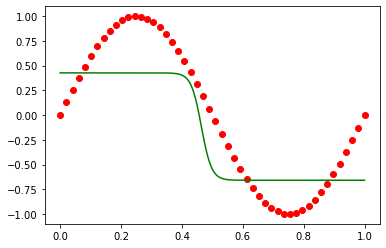

In [231]:
x = np.linspace(0, 1, 50)
y = np.sin(2*np.pi*x)

training_data = [(x, y) for x, y in zip(x, y)]

net1.gradient_descent(training_data, 0.00001)

test_x = np.linspace(0, 1, 1000)
prediction = []
for x1 in test_x:
    prediction.append(net1.feed_forward(x1).item(0))

fig, ax = plt.subplots()
ax.scatter(x, y, color = "red")
ax.plot(test_x, prediction, color = "green")

fig.show()

**Question 3**

We will build fifty-two different neural networks of various sizes.

In [214]:
diff_sizes = []
for i in range(5, 30, 5):
    for j in range(5, 30, 5):
        diff_sizes.append([1, i, j, 1])

for i in range(5, 20, 5):
    for j in range(5, 20, 5):
        for k in range(5, 20, 5):
            diff_sizes.append([1, i, j, k, 1])

In [215]:
x_train = np.linspace(0, 1, 30)
y_train = np.sin(2*np.pi*x_train) + np.random.normal(0, 0.1, 30)
training_data = [(x, y) for x, y in zip(x_train, y_train)]

test_x = np.linspace(0, 1, 1000)

Let's look at a plot of the training data.

<ipython-input-218-ac0513414d23>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


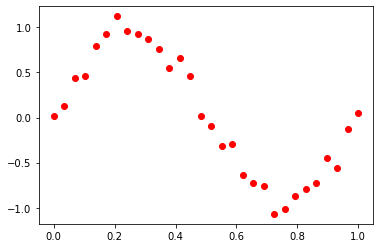

In [218]:
fig, ax = plt.subplots()
ax.scatter(x_train, y_train, color = "red")
fig.show()

Before looking at the fifty-two bigger models, we will first build three models with only one hidden layer, but varying number of neurons within that layer.

5 neurons:

<ipython-input-220-0baae416abd8>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


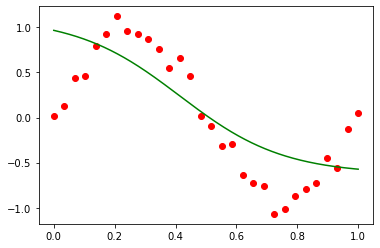

In [220]:
net = NeuralNetwork([1, 5, 1])
net.gradient_descent(training_data, 0.001)

prediction = []
for x1 in test_x:
    prediction.append(net1.feed_forward(x1).item(0))

fig, ax = plt.subplots()
ax.scatter(x_train, y_train, color = "red")
ax.plot(test_x, prediction, color = "green")
fig.show()

10 neurons:

<ipython-input-221-049f9916ef5f>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


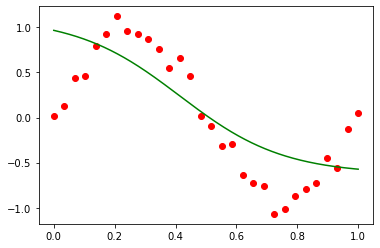

In [221]:
net = NeuralNetwork([1, 10, 1])
net.gradient_descent(training_data, 0.001)

prediction = []
for x1 in test_x:
    prediction.append(net1.feed_forward(x1).item(0))

fig, ax = plt.subplots()
ax.scatter(x_train, y_train, color = "red")
ax.plot(test_x, prediction, color = "green")
fig.show()

15 neurons:

<ipython-input-222-b4b4b982cce7>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


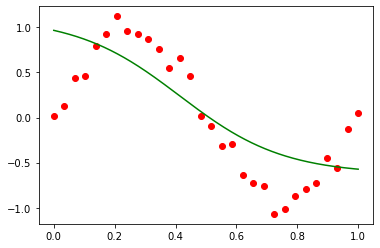

In [222]:
net = NeuralNetwork([1, 15, 1])
net.gradient_descent(training_data, 0.001)

prediction = []
for x1 in test_x:
    prediction.append(net1.feed_forward(x1).item(0))

fig, ax = plt.subplots()
ax.scatter(x_train, y_train, color = "red")
ax.plot(test_x, prediction, color = "green")
fig.show()

There is clearly something incorrect with my Neural Network code as when I attempt to build a model with more than one hidden layer my dot product calculation breaks. I apologize for not taking the time to fix it. 

In [198]:
for l in diff_sizes:
    print(l)
    net = NeuralNetwork(l)
    net.gradient_descent(training_data, 0.001)

    prediction = []
    for x1 in test_x:
        prediction.append(net1.feed_forward(x1).item(0))

    fig, ax = plt.subplots()
    ax.scatter(x_train, y_train, color = "red")
    ax.plot(test_x, prediction, color = "green")
    fig.show()
    

[1, 5, 5, 1]


ValueError: shapes (5,50) and (1,5) not aligned: 50 (dim 1) != 1 (dim 0)